In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import pystan

In [2]:
# Parameters
P = 10
N = 3*(10 ** 4)
SEED = 1729

In [3]:
# Ground truth
np.random.seed(SEED)
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)

t_i = np.random.beta(8, 2, 1)  # Prob(tested | infected)
t_not_i = np.random.beta(2, 20, 1)  # Prob(tested | not-infected)
true_gamma = np.array([t_i, t_not_i])

test_sensitivity = np.random.beta(8, 2, 1)  # True positive rate
test_specificity = np.random.beta(50, 2, 1)  # True negative rate
true_lambda = np.array([test_sensitivity, test_specificity])

In [5]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)

# Resampling using testing probabilites conditional on infected
tested = y*np.random.binomial(1, true_gamma[0], N) + (1-y)*np.random.binomial(1, true_gamma[1], N)
y = y[tested == 1]
X_survey = X[tested == 0].reset_index()
X = X[tested == 1].reset_index()

N = X.shape[0]
NA = X_survey.shape[0]

# Introducing false positives and negatives
y = y*np.random.binomial(1, true_lambda[0], N) + (1-y)*np.random.binomial(1, (1-true_lambda[1]), N)

X = X.loc[:, X.columns.str.startswith('O')]
X_survey = X_survey.loc[:, X_survey.columns.str.startswith('O')]
X.info()
X_survey.info()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8193 entries, 0 to 8192
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      8193 non-null   int64
 1   O2      8193 non-null   int64
 2   O3      8193 non-null   int64
 3   O4      8193 non-null   int64
 4   O5      8193 non-null   int64
 5   O6      8193 non-null   int64
 6   O7      8193 non-null   int64
 7   O8      8193 non-null   int64
 8   O9      8193 non-null   int64
 9   O10     8193 non-null   int64
dtypes: int64(10)
memory usage: 640.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21807 entries, 0 to 21806
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      21807 non-null  int64
 1   O2      21807 non-null  int64
 2   O3      21807 non-null  int64
 3   O4      21807 non-null  int64
 4   O5      21807 non-null  int64
 5   O6      21807 non-null  int64
 6   O7      21807 non-null  int64
 7   O8 

In [6]:
# Create model
sm = pystan.StanModel(model_name='tt_mod', model_code="""
data {
  int<lower=0> N;                            // number of test observations
  int<lower=0> NA;                           // number of survey observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences of tested individuals
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  int<lower=0, upper=1> survey[NA,P];        // activity occurrences of surveyed individuals
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
  real<lower=0, upper=1> gamma[2];           // Testing rates, given infected status [T|I , T|!I]
  real<lower=0, upper=1> lambda[2];          // True positive and true negative rates of tests [TP,TN]
}
model {
  // Precomputation
  real log1m_theta[P];
  real log1m_rho;
  real log_gamma[2];
  real log1m_gamma[2];
  real log_lambda[2];
  real log1m_lambda[2];
  
  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }
  for(i in 1:2){
    log_gamma[i] = log(gamma[i]);
    log1m_gamma[i] = log1m(gamma[i]);
    log_lambda[i] = log(lambda[i]);
    log1m_lambda[i] = log1m(lambda[i]);
  }
  
  log1m_rho = log1m(rho);
  
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  gamma ~ uniform(0, 1);
  lambda ~ uniform(0, 1);

  // Likelihood
  for (n in 1:NA) {
    real s = 0.0;
    for (p in 1:P) {
      if (survey[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    target += log_sum_exp((log1m_exp(s)+log1m_gamma[1]), (s+log1m_gamma[2]));
  }
  
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    
    if (y[n] == 1) {
      target += log_sum_exp((log1m_exp(s) + log_gamma[1] + log_lambda[1]), (s + log_gamma[2] + log1m_lambda[2]));
    } 
    else {
      target += log_sum_exp((s + log_gamma[2] + log_lambda[2]), (log1m_exp(s) + log_gamma[1] + log1m_lambda[1]));
    }
  }
}
""")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_resampled_mod_d71888936670d49f9409b48a46dfc936 NOW.


In [4]:
# Set NUTS parameters
nuts_samples = 1000
nuts_burnin = 500
nuts_chains = 16

In [7]:
# Fit model
start = time.time()
model_data = {'N': N, 'NA': NA, 'P': P, 'X': X.to_numpy(),
              'y': y.to_numpy(), 'survey': X_survey.to_numpy()}
fit = sm.sampling(
    data=model_data,
    iter=nuts_samples,
    warmup=nuts_burnin,
    chains=nuts_chains
)
print(f"{time.time() - start:.02f} seconds elapsed")

7595.94 seconds elapsed


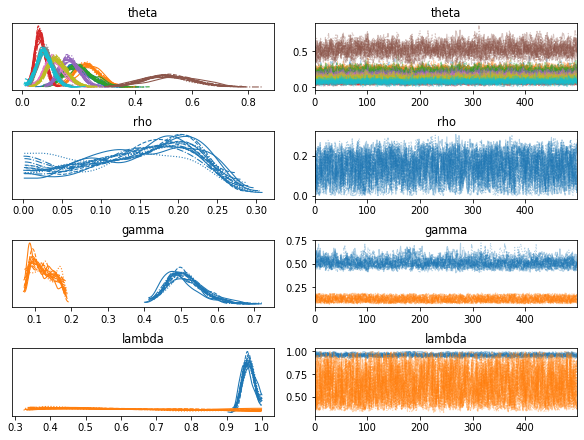

In [8]:
# Evaluate fit with test and trace resample
arviz.plot_trace(fit, figsize=(8, 6));

In [10]:
# View results
print("Inference on fitted model:")
print(fit)
print('')
print('Ground truth:')
print('Setting-specific transmission rates: ', true_transmission_rate)
print('Base rate: ', base_rate)
print('Testing rates: ', true_gamma)
print('True positive and negative rates: ', true_lambda)

Inference when trained with test and trace resampling:
Inference for Stan model: tt_resampled_mod_d71888936670d49f9409b48a46dfc936.
16 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    0.19  1.1e-3   0.05   0.11   0.16   0.19   0.22    0.3   2071   1.01
theta[2]    0.23  1.1e-3   0.04   0.16    0.2   0.23   0.26   0.32   1535   1.01
theta[3]     0.2  1.0e-3   0.05   0.12   0.17    0.2   0.23    0.3   2024   1.01
theta[4]    0.06  3.3e-4   0.02   0.03   0.05   0.06   0.08    0.1   3021    1.0
theta[5]    0.17  8.3e-4   0.03   0.11   0.14   0.17   0.19   0.24   1688   1.01
theta[6]    0.52  2.4e-3   0.08   0.37   0.46   0.52   0.58   0.69   1167   1.01
theta[7]    0.12  7.4e-4   0.04   0.05   0.09   0.11   0.14    0.2   2353    1.0
theta[8]    0.08  4.9e-4   0.03   0.04   0.07   0.08    0.1   0.14   2911    1.0
theta[9]    0.12  6.3e